# Masked Saliency Maps

## 1. Imports

In [1]:
import json
import pickle
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

from fours.models.noise import FourSNoise
from fours.utils.data_handling import read_fours_root_dir, load_adi_data
from fours.utils.masks import construct_rfrr_mask

In [2]:
root_dir = Path(read_fours_root_dir())

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


## 2. Input gradients for S4

In [3]:
# Load the noise model
noise_model_file = root_dir / Path("70_results/x1_fake_planet_experiments/HD22049_351_096_C-0679_A_/scratch/tensorboard_S4/models/noise_model_0000_lambda_010000.pkl")

s4_noise_model = FourSNoise.load(noise_model_file)

In [4]:
# Compute the input gradients
s4_noise_model.compute_betas()
input_gradients_4s = np.abs(s4_noise_model.betas.detach().numpy())
input_gradients_4s = input_gradients_4s.reshape(-1, 91, 91)

## 3. Input gradients for PCA

### 3.1 Load the data

In [5]:
dataset_name = "HD22049_351_096_C-0679_A_"
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")

In [6]:
science_data, angles, raw_psf_template = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template, axis=0)

In [7]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

### 3.2 Compute the PCA basis using SVD

In [8]:
# 1.) Convert images to torch tensor
im_shape = science_data.shape
images_torch = torch.from_numpy(science_data)

# 2.) remove the mean as needed for PCA
images_torch = images_torch - images_torch.mean(dim=0)

# 3.) reshape images to fit for PCA
images_torch = images_torch.view(im_shape[0], im_shape[1] * im_shape[2])

# 4.) compute PCA basis
_, _, V = torch.svd(images_torch)

### 3.3 Find optimal number of PCA components

In [9]:
cc_result_file = root_dir / Path("70_results/x1_fake_planet_experiments/contrast_curves/HD22049_351_096_C-0679_A_.pkl")

In [10]:
with open(cc_result_file, 'rb') as f:
    tmp_data = pickle.load(f)

In [11]:
all_cc_combined = pd.concat(tmp_data.values(), keys=tmp_data.keys(), axis=1)
# drop all columns that start with s4
all_cc_combined = all_cc_combined.loc[:, ~all_cc_combined.columns.get_level_values(0).str.startswith("s4")]
# round the index
all_cc_combined.index = np.round(all_cc_combined.index, 1)

In [12]:
# find the best number of PCA components at 2.5 lambda/D
best_pca = all_cc_combined.loc[2.5].argmax()
all_cc_combined.columns[best_pca][0]

'stacked_05_PCA_090_components'

In [13]:
pca_number = 90

### 3.4 Compute the input gradients

In [14]:
input_gradients_pca = torch.matmul(V[:, :pca_number], V[:, :pca_number].T)
input_gradients_pca = np.abs(input_gradients_pca.detach().numpy())
input_gradients_pca = input_gradients_pca.reshape(-1, 91, 91)

### 3.5 Maks input gradients

In [15]:
mask = construct_rfrr_mask(
    cut_off_radius=3.6 * 1.5,
    psf_template_in=psf_template,
    mask_size_in=91,
    use_template=False
)

In [16]:
input_gradients_pca = input_gradients_pca * mask

## 4. Plot the result

In [17]:
def plot_saliency_map(
    axis_in,
    input_gradients,
    position):
    
    idx = position[0] * 91 + position[1]
    axis_in.imshow(input_gradients[idx])
    axis_in.axis("off")
    
    axis_in.scatter(position[1], position[0], color="white", marker="+", s=50)
    axis_in.scatter(45, 45, color="red", marker="*", s=50)

In [18]:
# compute the distance between the point and the center
def distance_to_center(position):
    center = np.array([45, 45])
    return np.linalg.norm(np.array(position) - center)

# distance of position 1
distance_to_center((49, 37)) / 3.6

2.4845199749997664

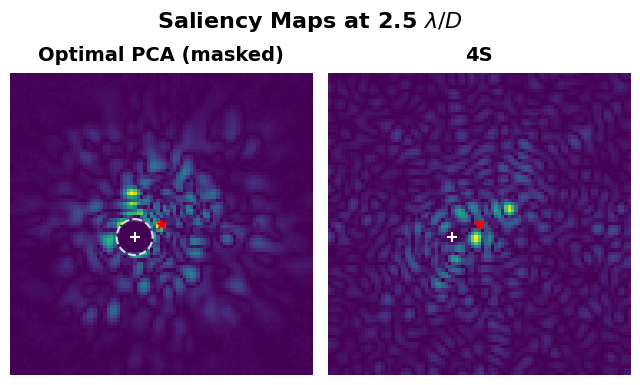

In [19]:
position = (49, 37)

# 1.) Create the Plot Layout ------------------------------
fig = plt.figure(
    constrained_layout=False,
    figsize=(8, 4))

gs0 = fig.add_gridspec(1, 2, width_ratios = [1, 1])
gs0.update(wspace=0.05, hspace=0.07)

# Residual Plots
example_pca = fig.add_subplot(gs0[0, 0])
example_4s = fig.add_subplot(gs0[0, 1])

plot_saliency_map(example_pca, input_gradients_pca, position)
plot_saliency_map(example_4s, input_gradients_4s, position)

# plot a dashed circle at the given position in the PCA plot
circle = plt.Circle(
    (position[1], position[0]),
    3.6 * 1.5,
    color="white",
    fill=False,
    alpha=0.8,
    linestyle="--",
    linewidth=1.5)

example_pca.add_artist(circle)

# Add Figure Title
example_pca.set_title(
    "Optimal PCA (masked)",
    fontsize=14,
    fontweight="bold",
    y=1.01)

example_4s.set_title(
    "4S",
    fontsize=14,
    fontweight="bold",
    y=1.01)

fig_title = fig.suptitle(
    "Saliency Maps at 2.5 $\lambda/D$",
    size=16, fontweight="bold", y=1.03)


fig.patch.set_facecolor('white')
plt.savefig("./final_plots/0a5_maked_sailency_map.pdf",
            bbox_inches='tight')